In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import json
from tqdm import tqdm
import seaborn as sns

from importlib import reload
import utils
reload(utils)

from utils import load_mutations_data, load_neural_stats, load_tensorboard_data, collect_sweep_results

## Final scores for WandB logging

In [7]:
all_step_stats, all_summary_stats_combined = collect_sweep_results(
    log_dir='/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/variance_tests_10iter',
    run_names=[
        'pysr-difficult_eq-11',
        'pysr-difficult_eq-12',
        'pysr-difficult_eq-13',
    ],
    keep_single_runs=False,
    combined_prefix='mean-'
)

In [ ]:
import sys
sys.path.append('/cephfs/home/lc865/workspace/similar-expressions/src/SR_benchmarking')
from run.benchmarking_utils import (
    NeuralOptions,
    MutationWeights,
    ModelSettings,
    DatasetSettings,
    init_pysr_model,
    run_single
)
from typing import Dict, Any, Tuple, Union

def lit2num(x: str) -> Union[float, int, str]:
    try:
        tmp = float(x)
        if tmp.is_integer():
            tmp = int(tmp)
    except:
        tmp = x
    return tmp

def merge_configs(
        model_settings: ModelSettings, 
        mutation_weights: MutationWeights, 
        neural_options: NeuralOptions, 
        wandb_config: Dict[str, Any]
) -> Tuple[ModelSettings, MutationWeights, NeuralOptions]:
    
    def _set_attr_safely(obj, key, value):
        if hasattr(obj, key):
            setattr(obj, key, value)
        else:
            raise AttributeError(f"Settings object {type(obj).__name__} has no attribute '{key}'")

    for k, v in wandb_config.items():
        category, key = k.split('.')
        if category == 'model_settings':
            _set_attr_safely(model_settings, key, lit2num(v))
        elif category == 'mutation_weights':
            _set_attr_safely(mutation_weights, key, lit2num(v))
        elif category == 'neural_options':
            _set_attr_safely(neural_options, key, lit2num(v))
        else:
            raise ValueError(f'Unknown category: {category}')

    return model_settings, mutation_weights, neural_options

cfg = {
    'mutation_weights.weight_add_node': '0.32635049772048697',
    'mutation_weights.weight_delete_node': '0.08398250124278872',
}

merge_configs(
    ModelSettings(),
    MutationWeights(),
    NeuralOptions(),
    cfg
)

AttributeError: Settings object MutationWeights has no attribute 'weight_add_node2'

## Misc old

In [ ]:
path_logdir = '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/variance_tests/feynman_eq1'
df = load_mutations_data(path_logdir)
df['loss_ratio'] = df['loss_after'] / df['loss_before']
df['is_inf'] = np.isinf(df.score_after) | np.isinf(df.loss_after)

In [ ]:
# Calculate histogram for each mutation type using the specified bins
def hist_by_category(df: pd.DataFrame, category_col: str, value_col: str, bins: list, bin_labels: list, plot: bool = True, return_df: bool = False) -> None:
    hist_data = {}
    for cat in df[category_col].unique():
        subset = df[df[category_col] == cat][value_col]
        hist, _ = np.histogram(subset, bins=bins)
        percentages = (hist / len(subset) * 100).round(1)
        hist_data[cat] = percentages

    hist_df2 = pd.DataFrame(hist_data, index=bin_labels).T

    # Create a heatmap with percentages
    if plot:
        plt.figure(figsize=(6, 3))
        heatmap = sns.heatmap(hist_df2, annot=True, cmap="YlGnBu", fmt='.1f', 
                            linewidths=.5, cbar_kws={'label': 'Percentage (%)'}, cbar=False)
        plt.title('Distribution of Loss Difference by Mutation Type')
        plt.ylabel(category_col)
        plt.xlabel(f'Range of {value_col}')
        plt.tight_layout()
    if return_df:
        return hist_df2

hist_by_category(
    df, 
    category_col='mutation_type', 
    value_col='loss_ratio', 
    bins=[-np.inf, 1-1e-12, 1+1e-12, 1.1, 10, np.inf], 
    bin_labels=['< ~1', '~1', '[~1, 1.1]', '[1.1, 10]', '> 10'],
    plot=False,
    return_df=True
)

,< ~1,~1,"[~1, 1.1]","[1.1, 10]",> 10
insert_node,6.4,4.8,4.1,15.5,69.2
rotate_tree,1.1,44.1,3.0,7.7,44.1
mutate_operator,0.7,25.4,1.2,11.3,61.3
neural_mutate_tree,1.8,32.4,2.2,11.5,52.1
do_nothing,0.0,100.0,0.0,0.0,0.0
delete_node,3.9,9.3,3.4,15.4,68.1
add_node,5.4,3.1,2.5,12.8,76.2
randomize,1.7,0.4,0.3,3.0,94.6
swap_operands,0.2,33.5,0.8,3.7,61.8
mutate_constant,3.3,2.3,5.6,25.6,63.1


In [28]:
# Show results reason by mutation count
# Get counts by mutation type and result reason
def result_reason_by_mutation_type(df: pd.DataFrame, ratio: bool = False):
    counts_df = df.groupby('mutation_type')['result_reason'].value_counts().unstack().fillna(0).astype(int)

    # Add sum of each mutation type
    counts_df['sum'] = counts_df.sum(axis=1)

    if not ratio:
        return counts_df
    else:
        ratio_df = (counts_df.div(counts_df['sum'], axis=0)*100).round(1).drop(columns=['sum'])
        return ratio_df

result_reason_by_mutation_type(df, ratio=False)
result_reason_by_mutation_type(df, ratio=True)

result_reason,annealing_or_frequency,failed_constraint_check,pass
mutation_type,,,
add_node,37.0,0.0,63.0
delete_node,16.8,0.0,83.2
do_nothing,0.0,0.0,100.0
insert_node,36.9,0.0,63.1
mutate_constant,0.0,0.0,100.0
mutate_operator,0.0,0.0,100.0
neural_mutate_tree,20.4,0.4,79.2
randomize,33.3,0.0,66.7
rotate_tree,0.0,0.0,100.0


## Variance checks

In [35]:
from tqdm import trange

all_dfs = []
for eq_idx in trange(1, 18):
    path_logdir = f'/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/initial_variance_tests/synthetic_eq{eq_idx}'
    df = load_mutations_data(path_logdir)
    df['loss_ratio'] = df['loss_after'] / df['loss_before']

    all_dfs.append(hist_by_category(
        df, 
        category_col='mutation_type', 
        value_col='loss_ratio', 
        bins=[-np.inf, 2, np.inf],  # [-np.inf, 1-1e-12, 1+1e-12, 1.1, 10, np.inf], 
        bin_labels=['< 2', '> 2'],  # ['< ~1', '~1', '[~1, 1.1]', '[1.1, 10]', '> 10'],
        plot=False,
        return_df=True
    ).sort_index())
stacked = np.stack([df.values for df in all_dfs])
mean, err = stacked.mean(axis=0), stacked.std(axis=0)/np.sqrt(stacked.shape[0])
display(pd.DataFrame(mean, index=all_dfs[0].index, columns=all_dfs[0].columns).round(1))
display(pd.DataFrame(err, index=all_dfs[0].index, columns=all_dfs[0].columns).round(1))

100%|██████████| 17/17 [00:07<00:00,  2.36it/s]


,< 2,> 2
add_node,55.2,44.8
delete_node,62.0,38.0
do_nothing,100.0,0.0
insert_node,61.1,38.9
mutate_constant,61.6,38.4
mutate_operator,64.2,35.8
neural_mutate_tree,75.0,25.0
randomize,32.0,68.0
rotate_tree,66.4,33.6
simplify,100.0,0.0


,< 2,> 2
add_node,4.0,4.0
delete_node,3.1,3.1
do_nothing,0.0,0.0
insert_node,3.4,3.4
mutate_constant,3.2,3.2
mutate_operator,2.8,2.8
neural_mutate_tree,2.4,2.4
randomize,5.0,5.0
rotate_tree,2.7,2.7
simplify,0.0,0.0


In [34]:
all_dfs = []
for eq_idx in trange(20):
    path_logdir = f'/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/variance_tests/synthetic_eq{eq_idx}'
    df = load_mutations_data(path_logdir)
    df['loss_ratio'] = df['loss_after'] / df['loss_before']

    all_dfs.append(result_reason_by_mutation_type(df, ratio=False).sort_index())

stacked = np.stack([df.values for df in all_dfs])
mean, std = stacked.mean(axis=0), stacked.std(axis=0)
display(pd.DataFrame(mean, index=all_dfs[0].index, columns=all_dfs[0].columns).round(1))
display(pd.DataFrame(std, index=all_dfs[0].index, columns=all_dfs[0].columns).round(1))

100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


result_reason,annealing_or_frequency,failed_constraint_check,pass,sum
mutation_type,,,,
add_node,696.4,0.2,1061.6,1758.2
delete_node,1692.5,0.0,8710.8,10403.2
do_nothing,0.0,0.0,12208.0,12208.0
insert_node,22076.0,3.4,33416.2,55495.6
mutate_constant,0.0,0.0,477.6,477.6
mutate_operator,0.0,0.0,102392.0,102392.0
neural_mutate_tree,6032.2,133.2,22188.2,28353.6
randomize,73.9,0.0,121.6,195.5
rotate_tree,0.0,0.0,40218.8,40218.8


result_reason,annealing_or_frequency,failed_constraint_check,pass,sum
mutation_type,,,,
add_node,38.2,0.6,82.4,96.5
delete_node,162.8,0.0,179.6,145.0
do_nothing,0.0,0.0,182.5,182.5
insert_node,1276.0,2.2,2213.4,2605.9
mutate_constant,0.0,0.0,40.4,40.4
mutate_operator,0.0,0.0,1634.7,1634.7
neural_mutate_tree,449.2,40.7,576.7,416.4
randomize,10.4,0.0,12.0,9.9
rotate_tree,0.0,0.0,534.0,534.0


In [27]:
# Filter out infinite values
filtered_df = df[~df.is_inf]

# Group by mutation_type and calculate different metrics
metric = 'loss_ratio'
result = pd.DataFrame({
    'median': filtered_df.groupby('mutation_type')[metric].median(),
    'geo_mean': filtered_df.groupby('mutation_type').apply(
        lambda x: np.exp(np.mean(np.log(np.abs(x[metric]) + 1e-10))) * np.sign(np.mean(x[metric]))
    ),
    'log_transform_mean': filtered_df.groupby('mutation_type').apply(
        lambda x: np.mean(np.sign(x[metric]) * np.log1p(np.abs(x[metric])))
    ),
    'trimmed_mean': filtered_df.groupby('mutation_type')[metric].apply(
        lambda x: np.percentile(x, [10, 90]).mean()  # Alternative way to get trimmed mean
    ),
    'winsorized_mean': filtered_df.groupby('mutation_type')[metric].apply(
        lambda x: np.mean(np.clip(x, np.percentile(x, 5), np.percentile(x, 95)))  # Winsorize at 5th and 95th percentiles
    ),
    'percent_<1': filtered_df.groupby('mutation_type')[metric].apply(
        lambda x: (x < 1).mean() * 100  # Calculate percentage of negative values
    ),
    'percent_<5': filtered_df.groupby('mutation_type')[metric].apply(
        lambda x: (x < 5).mean() * 100  # Calculate percentage of negative values
    ),
    'percent_<10': filtered_df.groupby('mutation_type')[metric].apply(
        lambda x: (x < 10).mean() * 100  # Calculate percentage of negative values
    )
})

# Display the result dataframe
display(result.round(1))

# Create a figure with multiple subplots for different metrics
fig, axes = plt.subplots(len(result.columns), 1, figsize=(10, 16), sharex=True)
metrics = ['median', 'geo_mean', 'log_transform_mean', 'trimmed_mean', 'winsorized_mean', 'percent_<1', 'percent_<5', 'percent_<10']

for i, metric in enumerate(metrics):
    result[metric].plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(f'{metric.replace("_", " ").title()}')
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for j, v in enumerate(result[metric]):
        axes[i].text(j, v + (0.1 if v >= 0 else -0.1), 
                    f'{v:.2f}', ha='center', va='center' if v >= 0 else 'top',
                    fontweight='bold', fontsize=8)

plt.tight_layout()
plt.xlabel('Mutation Type')
plt.suptitle('Loss Difference Metrics by Mutation Type', fontsize=16, y=1.02)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'is_inf'

### Tree-edit distance

In [29]:
df[['mutation_type', 'TED']].groupby('mutation_type').TED.describe().round(1)

,count,mean,std,min,25%,50%,75%,max
mutation_type,,,,,,,,
add_node,1772.0,7.7,8.7,1.0,1.0,2.0,12.0,38.0
delete_node,10391.0,2.6,4.5,0.0,0.0,0.0,3.0,37.0
do_nothing,12276.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
insert_node,55271.0,3.9,4.5,1.0,1.0,2.0,4.0,38.0
mutate_constant,481.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mutate_operator,102063.0,0.8,0.4,0.0,1.0,1.0,1.0,1.0
neural_mutate_tree,28486.0,2.7,2.9,0.0,0.0,2.0,5.0,15.0
randomize,195.0,19.2,7.7,0.0,14.0,20.0,25.5,37.0
rotate_tree,40339.0,5.6,6.1,0.0,2.0,4.0,7.0,39.0


### Combined metrics

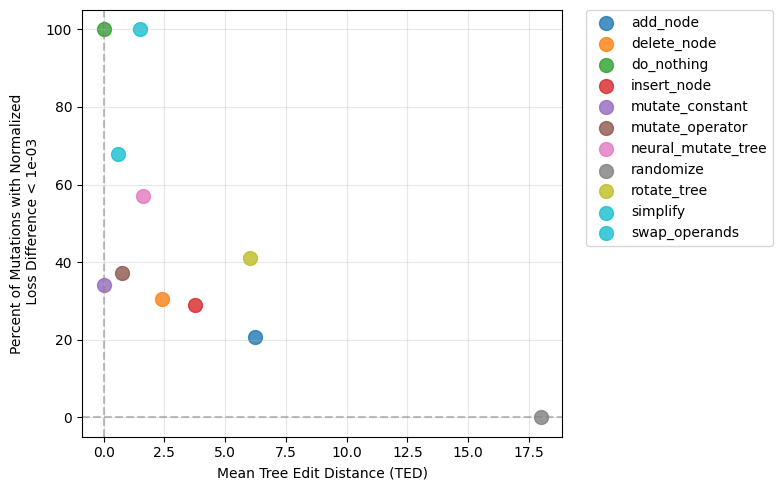

In [57]:
# Calculate mean TED for each mutation type
mean_ted = df.groupby('mutation_type')['TED'].mean()

# Calculate percent negative score_diff for each mutation type (excluding infinities)
# Negative score_diff is good (improvement)
percent_smaller_than_01 = df[~df.is_inf].groupby('mutation_type')['loss_diff_norm'].apply(
    lambda x: (x < 1e-3).mean() * 100  # Calculate percentage of negative values
)

# Combine the data
plot_data = pd.DataFrame({
    'TED': mean_ted,
    'lossImprovRate': percent_smaller_than_01
}).dropna()  # Remove any rows with NaN values

# Create scatter plot with color coding
plt.figure(figsize=(8, 5))

# Create a colormap
colors = plt.cm.tab10(np.linspace(0, 1, len(plot_data)))

# Plot each point with a different color
for i, (idx, row) in enumerate(plot_data.iterrows()):
    plt.scatter(row['TED'], row['lossImprovRate'], 
                s=100, alpha=0.8, color=colors[i], label=idx)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.xlabel('Mean Tree Edit Distance (TED)')
plt.ylabel(f'Percent of Mutations with Normalized\n Loss Difference < {1e-3:.0e}')
plt.grid(True, alpha=0.3)

# Add legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()

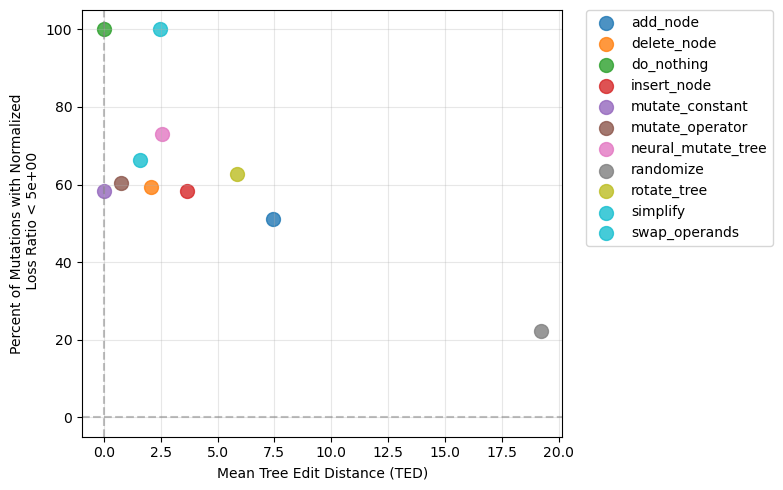

In [81]:
# Calculate mean TED for each mutation type
mean_ted = df.groupby('mutation_type')['TED'].mean()

# Calculate percent negative score_diff for each mutation type (excluding infinities)
# Negative score_diff is good (improvement)
percent_smaller_than_01 = df[~df.is_inf].groupby('mutation_type')['loss_ratio'].apply(
    lambda x: (x < 2).mean() * 100  # Calculate percentage of negative values
)

# Combine the data
plot_data = pd.DataFrame({
    'TED': mean_ted,
    'lossImprovRate': percent_smaller_than_01
}).dropna()  # Remove any rows with NaN values

# Create scatter plot with color coding
plt.figure(figsize=(8, 5))

# Create a colormap
colors = plt.cm.tab10(np.linspace(0, 1, len(plot_data)))

# Plot each point with a different color
for i, (idx, row) in enumerate(plot_data.iterrows()):
    plt.scatter(row['TED'], row['lossImprovRate'], 
                s=100, alpha=0.8, color=colors[i], label=idx)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.xlabel('Mean Tree Edit Distance (TED)')
plt.ylabel(f'Percent of Mutations with Normalized\n Loss Ratio < {5:.0e}')
plt.grid(True, alpha=0.3)

# Add legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()

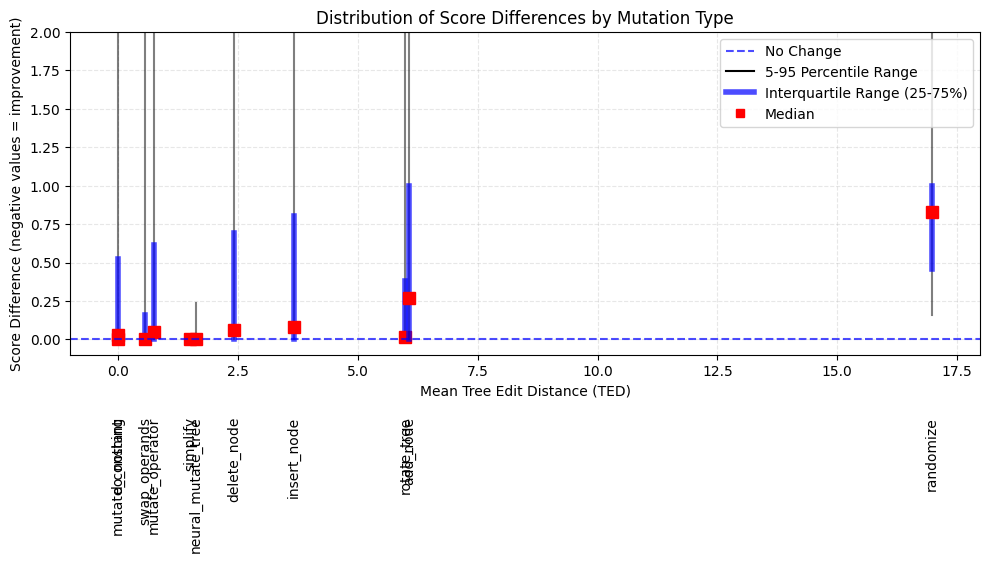

In [25]:
# Create a plot with boxplot-style visualization for each mutation type
# showing median and percentiles of score_diff

# Filter out infinities for better visualization
filtered_df = df[~df.is_inf]

# Calculate statistics for each mutation type
stats = filtered_df.groupby('mutation_type').agg({
    'score_diff': [
        ('median', 'median'),
        ('q25', lambda x: x.quantile(0.25)),
        ('q75', lambda x: x.quantile(0.75)),
        ('min', lambda x: x.quantile(0.05)),  # Using 5th percentile instead of min to avoid outliers
        ('max', lambda x: x.quantile(0.95))   # Using 95th percentile instead of max to avoid outliers
    ],
    'TED': [('mean', 'mean')]  # Add mean TED calculation
}).reset_index()

# Flatten the multi-level columns
stats.columns = ['_'.join(col).strip('_') for col in stats.columns.values]

# Sort by median for better visualization
stats = stats.sort_values('score_diff_median')

# Create the figure
plt.figure(figsize=(10, 6))

# Plot each mutation type as a vertical line with markers
for i, row in enumerate(stats.itertuples()):
    mutation = row.mutation_type
    
    # Use the mean TED as the x position instead of the index
    x_pos = row.TED_mean
    
    # Plot the min-max line (5-95 percentile range)
    plt.plot([x_pos, x_pos], [row.score_diff_min, row.score_diff_max], 'k-', alpha=0.5)
    
    # Plot the interquartile range as a thicker, colored line for better visibility
    plt.plot([x_pos, x_pos], [row.score_diff_q25, row.score_diff_q75], 'b-', linewidth=4, alpha=0.7)
    
    # Plot the median as a distinct marker
    plt.plot(x_pos, row.score_diff_median, 'rs', markersize=8)
    
    # Plot the mean as a square marker
    # plt.plot(x_pos, row.TED_mean, 'gs', markersize=8)
    
    # Add the mutation type label
    plt.text(x_pos, stats['score_diff_min'].min() - 0.5, mutation, ha='center', va='top', rotation=90)

# Add a horizontal line at y=0 to show the boundary between improvement and degradation
plt.axhline(y=0, color='blue', linestyle='--', alpha=0.7, label='No Change')

# Set the x-axis limits to give some padding
plt.xlim(stats['TED_mean'].min() - 1, stats['TED_mean'].max() + 1)

# Add labels and title
plt.xlabel('Mean Tree Edit Distance (TED)')
plt.ylabel('Score Difference (negative values = improvement)')
plt.title('Distribution of Score Differences by Mutation Type')

# Add a legend to explain the plot elements
plt.plot([], [], 'k-', label='5-95 Percentile Range')
plt.plot([], [], 'b-', linewidth=4, alpha=0.7, label='Interquartile Range (25-75%)')
plt.plot([], [], 'rs', label='Median')
# plt.plot([], [], 'gs', label='Mean TED')
plt.legend(loc='best')

# Add grid lines for better readability
plt.grid(linestyle='--', alpha=0.3)

plt.ylim(-0.1, 2)

plt.tight_layout()
plt.show()
